### The goal is to create a predictive model for classifying new bookings as to whether they will eventually gets cancelled due to car unavailability.

In [93]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import haversine as hs #To calculate distance using from_lat, from_long, to_lat, to_lang

In [94]:
#Filter warnings
import warnings
warnings.filterwarnings('ignore')

In [95]:
#import data
real_df = pd.read_csv('Yourcab/YourCabs_training.csv')

In [96]:
pd.set_option('display.max_columns', None)

In [97]:
real_df.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,NaN,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0,1.0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0,1.0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,NaN,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0,1.0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,NaN,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0,1.0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0,1.0


In [98]:
temp_df = real_df.copy()

In [99]:
#Separate Target and Predictor Variable
X = temp_df.drop(columns=['Car_Cancellation', 'Cost_of_error'], axis=1)
Y = temp_df['Car_Cancellation']

#### X: Predictor Features
#### Y: Target Features

In [100]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   43431 non-null  int64  
 1   user_id              43431 non-null  int64  
 2   vehicle_model_id     43431 non-null  int64  
 3   package_id           7550 non-null   float64
 4   travel_type_id       43431 non-null  int64  
 5   from_area_id         43343 non-null  float64
 6   to_area_id           34293 non-null  float64
 7   from_city_id         16345 non-null  float64
 8   to_city_id           1588 non-null   float64
 9   from_date            43431 non-null  object 
 10  to_date              25541 non-null  float64
 11  online_booking       43431 non-null  int64  
 12  mobile_site_booking  43431 non-null  int64  
 13  booking_created      43431 non-null  object 
 14  from_lat             43338 non-null  float64
 15  from_long            43338 non-null 

In [101]:
#Calculate null value percentage in the data
X.isnull().mean()*100

id                      0.000000
user_id                 0.000000
vehicle_model_id        0.000000
package_id             82.616104
travel_type_id          0.000000
from_area_id            0.202620
to_area_id             21.040271
from_city_id           62.365591
to_city_id             96.343626
from_date               0.000000
to_date                41.191775
online_booking          0.000000
mobile_site_booking     0.000000
booking_created         0.000000
from_lat                0.214133
from_long               0.214133
to_lat                 21.040271
to_long                21.040271
dtype: float64

### Data Cleaning

In [102]:
# Identity Column: id, user_id
# Feature containing >30% Data null : package_id, from_city_id, to_city_id, to_date
X.drop(columns=['id', 'user_id', 'package_id', 'to_area_id', 'from_city_id', 'to_city_id', 'to_date'],
       axis=1, inplace=True)

In [103]:
X['vehicle_model_id'].value_counts(normalize=True)*100
#As 73% of the data in 'vehicle_model_id' is of id 12, It'll make model to overfitting, Drop this column

12    73.355437
85     5.542124
89     5.505284
65     4.402385
28     3.918860
24     3.439939
87     1.300914
90     0.718381
23     0.683843
86     0.283208
10     0.239460
64     0.195713
54     0.168083
17     0.092100
91     0.057563
30     0.032235
36     0.020723
13     0.016118
1      0.004605
43     0.004605
72     0.004605
14     0.002303
76     0.002303
75     0.002303
39     0.002303
70     0.002303
69     0.002303
Name: vehicle_model_id, dtype: float64

In [104]:
X.drop(columns=['vehicle_model_id'], axis=1, inplace=True) #Drop vehicle_model_id column

### Data Transformation

In [105]:
#The missing value for from_lat and from_long is 0.21%, impute it by median
print(X['from_lat'].median())
print(X['from_long'].median())

12.968887
77.63575


In [106]:
X['from_lat'] = X['from_lat'].fillna(X['from_lat'].median())
X['from_long'] = X['from_long'].fillna(X['from_long'].median())

In [107]:
#88 rows of 'from_area_id' is null, fill it by 
#1. Compare 'from_lat' with median of 'from_lat'
#2. find maximum repetition  of 'from_area_id'
#3. fill null values by that repetition
X['from_area_id'] = X['from_area_id'].fillna(X[X['from_lat']==X['from_lat'].median()]['from_area_id'].max())

In [108]:
X['to_lat'] = X['to_lat'].fillna(real_df.groupby('from_area_id')['to_lat'].transform('median'))
X['to_long'] = X['to_long'].fillna(real_df.groupby('from_area_id')['to_long'].transform('median'))

In [109]:
X['to_lat'].isna().sum()

105

In [110]:
X['to_long'].isna().sum()

105

In [111]:
#Fill the median in 'to_lat' and 'to_long' to null values
X['to_lat'] = X['to_lat'].fillna(X['to_lat'].median())
X['to_long'] = X['to_long'].fillna(X['to_long'].median())

In [112]:
X['to_lat'].isna().sum()

0

In [113]:
X.isnull().sum()

travel_type_id         0
from_area_id           0
from_date              0
online_booking         0
mobile_site_booking    0
booking_created        0
from_lat               0
from_long              0
to_lat                 0
to_long                0
dtype: int64

In [114]:
#check to_long, to_lat value for respective from_area_id is changed or not
X[X['from_area_id'] == 142].head()

,travel_type_id,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long
25,2,142.0,1/1/2013 17:00,1,0,1/1/2013 14:56,12.91281,77.60923,13.19956,77.70688
47,3,142.0,1/2/2013 3:00,0,0,1/1/2013 19:37,12.91281,77.60923,13.03017,77.70651
76,3,142.0,1/2/2013 10:30,0,0,1/2/2013 9:18,12.91281,77.60923,13.03017,77.70651
316,2,142.0,1/5/2013 16:30,0,0,1/5/2013 13:15,12.91281,77.60923,12.97677,77.57270
338,2,142.0,1/7/2013 8:00,0,0,1/5/2013 17:32,12.91281,77.60923,13.02853,77.54625


In [115]:
#One hot encodeing for travel type id
travel_type_id = pd.get_dummies(X['travel_type_id'], drop_first=True)

In [116]:
#Rename columns
travel_type_id.rename(columns={2:'point_to_point', 3:'hourly_rental'}, inplace=True)

In [117]:
#concatenate travel_type_id data frame and X
X = pd.concat([travel_type_id,X], axis=1)
X.drop(columns=['travel_type_id'], axis=1, inplace=True) #drop travel_type_id

In [118]:
#Function to calculate distance in KM
def cal_distance(from_lat, from_long, to_lat, to_long):
    return hs.haversine((from_lat, from_long), (to_lat, to_long))

In [119]:
#Create new feature 'Distance_in_KM'
X['Distance_in_KM'] = X.apply(lambda value: cal_distance(value['from_lat'], value['from_long'], value['to_lat'], value['to_long']),axis=1)

In [120]:
#CHeck any distance is less than 0 or not
X[X['Distance_in_KM']<0]

,point_to_point,hourly_rental,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Distance_in_KM


In [121]:
#Drop from_lat, from_long, to_lat, to_lang
#Distance is calculated
X.drop(columns=['from_lat', 'from_long', 'to_lat', 'to_long'], inplace=True)

In [122]:
X.head()

,point_to_point,hourly_rental,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,Distance_in_KM
0,1,0,83.0,1/1/2013 2:00,0,0,1/1/2013 1:39,3.975770
1,1,0,1010.0,1/1/2013 9:00,0,0,1/1/2013 2:25,13.995053
2,1,0,1301.0,1/1/2013 3:30,0,0,1/1/2013 3:08,12.708431
3,1,0,768.0,1/1/2013 5:45,0,0,1/1/2013 4:39,9.525167
4,1,0,1365.0,1/1/2013 9:00,0,0,1/1/2013 7:53,14.699802


In [123]:
X['from_date'].unique()

array(['1/1/2013 2:00', '1/1/2013 9:00', '1/1/2013 3:30', ...,
       '11/26/2013 1:00', '11/24/2013 18:30', '11/25/2013 5:00'],
      dtype=object)

In [124]:
#Dtype of feature 'from_date'  and 'booking_created' is object, we can extract the booking day, month, date and time
X['from_time_time'] = pd.to_datetime(X['from_date']).dt.strftime('%H:%M')
X['from_date_date'] = pd.to_datetime(X['from_date']).dt.strftime('%m/%d/%Y')
X['from_date_day'] = pd.to_datetime(X['from_date']).dt.day_name()
X['from_date_month'] = pd.to_datetime(X['from_date']).dt.month_name()

X['booking_created_time'] = pd.to_datetime(X['booking_created']).dt.strftime('%H:%M')
X['booking_created_date'] = pd.to_datetime(X['booking_created']).dt.strftime('%m/%d/%Y')
X['booking_created_day'] = pd.to_datetime(X['booking_created']).dt.day_name()
X['booking_created_month'] = pd.to_datetime(X['booking_created']).dt.month_name()

In [125]:
#Drop 'from_date', 'booking_created' columns
X.drop(columns=['from_date', 'booking_created'], inplace=True)

In [126]:
#Transform weekday/weekend feature from from_date_day, booking_created_day 
X['from_date_week'] = np.where((X['from_date_day']=='Saturday') | (X['from_date_day'] == 'Sunday'), 'Weekend', 'Weekday')
X['booking_created_week'] = np.where((X['booking_created_day'] == 'Saturday') | (X['booking_created_day'] == 'Sunday'), 'Weekend', 'Weekday')

In [127]:
#Convert from_time_time and booking_created timings into sessions like 'Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late Night'
cond = [(pd.to_datetime(X['from_time_time']).dt.hour.between(4,8)), 
       (pd.to_datetime(X['from_time_time']).dt.hour.between(9,12)),
       (pd.to_datetime(X['from_time_time']).dt.hour.between(13,16)),
       (pd.to_datetime(X['from_time_time']).dt.hour.between(17,20)),
       (pd.to_datetime(X['from_time_time']).dt.hour.between(21,24)) | (pd.to_datetime(X['from_time_time']).dt.hour==0),
       (pd.to_datetime(X['from_time_time']).dt.hour.between(1,3))]
value = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late Night']
X['from_date_session'] = np.select(cond, value)

In [128]:
cond = [(pd.to_datetime(X['booking_created_time']).dt.hour.between(4,8)), 
       (pd.to_datetime(X['booking_created_time']).dt.hour.between(9,12)),
       (pd.to_datetime(X['booking_created_time']).dt.hour.between(13,16)),
       (pd.to_datetime(X['booking_created_time']).dt.hour.between(17,20)),
       (pd.to_datetime(X['booking_created_time']).dt.hour.between(21,24) | (pd.to_datetime(X['booking_created_time']).dt.hour==0)),
       (pd.to_datetime(X['booking_created_time']).dt.hour.between(1,3))]
value = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late Night']
X['booking_created_session'] = np.select(cond, value)

In [129]:
X.booking_created_session.value_counts()

Morning          11131
Evening          10540
Afternoon        10242
Night             7128
Early Morning     3557
Late Night         833
Name: booking_created_session, dtype: int64

In [130]:
X.drop(columns=['from_time_time', 'booking_created_time'], inplace=True,axis=1)

In [131]:
X.drop(columns=['from_date_date', 'booking_created_date'], inplace=True)

In [132]:
X.head()

,point_to_point,hourly_rental,from_area_id,online_booking,mobile_site_booking,Distance_in_KM,from_date_day,from_date_month,booking_created_day,booking_created_month,from_date_week,booking_created_week,from_date_session,booking_created_session
0,1,0,83.0,0,0,3.975770,Tuesday,January,Tuesday,January,Weekday,Weekday,Late Night,Late Night
1,1,0,1010.0,0,0,13.995053,Tuesday,January,Tuesday,January,Weekday,Weekday,Morning,Late Night
2,1,0,1301.0,0,0,12.708431,Tuesday,January,Tuesday,January,Weekday,Weekday,Late Night,Late Night
3,1,0,768.0,0,0,9.525167,Tuesday,January,Tuesday,January,Weekday,Weekday,Early Morning,Early Morning
4,1,0,1365.0,0,0,14.699802,Tuesday,January,Tuesday,January,Weekday,Weekday,Morning,Early Morning


In [133]:
#Calculate the car cancellation rate for the 'from_area_id' feature
# rate = No of cancellation in the specific area_id/Total count of that area id
# data_merge.groupby('from_area_id')['Car_Cancellation'].sum()/data_merge.groupby('from_area_id')['Car_Cancellation'].count()
#Instead we can take mean()
data_merge = pd.concat([X,Y], axis=1, join='inner')

In [134]:
X['from_area_id'] = round(data_merge.groupby('from_area_id')['Car_Cancellation'].mean(),2)

In [135]:
X['from_area_id'].replace(np.NaN, 0,inplace=True)

In [136]:
#COnvert from_area_if feature to 
cond = [(X['from_area_id'].between(0.0,0.33)),
       (X['from_area_id'].between(0.34,0.66)),
       (X['from_area_id'].between(0.67,1.0))]
value = ['Low Cancellation', 'Medium Cancellation', 'High Cancellation']
X['from_area_id'] = np.select(cond, value)

### Visualization

In [137]:
X.head()

,point_to_point,hourly_rental,from_area_id,online_booking,mobile_site_booking,Distance_in_KM,from_date_day,from_date_month,booking_created_day,booking_created_month,from_date_week,booking_created_week,from_date_session,booking_created_session
0,1,0,Low Cancellation,0,0,3.975770,Tuesday,January,Tuesday,January,Weekday,Weekday,Late Night,Late Night
1,1,0,Low Cancellation,0,0,13.995053,Tuesday,January,Tuesday,January,Weekday,Weekday,Morning,Late Night
2,1,0,Low Cancellation,0,0,12.708431,Tuesday,January,Tuesday,January,Weekday,Weekday,Late Night,Late Night
3,1,0,Low Cancellation,0,0,9.525167,Tuesday,January,Tuesday,January,Weekday,Weekday,Early Morning,Early Morning
4,1,0,Low Cancellation,0,0,14.699802,Tuesday,January,Tuesday,January,Weekday,Weekday,Morning,Early Morning


In [138]:
#Saperate numerical feature and categorical feature
X_char = X.select_dtypes(include='object')
X_num = X.select_dtypes(include='number')

In [139]:
X_char.head()

,from_area_id,from_date_day,from_date_month,booking_created_day,booking_created_month,from_date_week,booking_created_week,from_date_session,booking_created_session
0,Low Cancellation,Tuesday,January,Tuesday,January,Weekday,Weekday,Late Night,Late Night
1,Low Cancellation,Tuesday,January,Tuesday,January,Weekday,Weekday,Morning,Late Night
2,Low Cancellation,Tuesday,January,Tuesday,January,Weekday,Weekday,Late Night,Late Night
3,Low Cancellation,Tuesday,January,Tuesday,January,Weekday,Weekday,Early Morning,Early Morning
4,Low Cancellation,Tuesday,January,Tuesday,January,Weekday,Weekday,Morning,Early Morning


In [140]:
X_num.head()

,point_to_point,hourly_rental,online_booking,mobile_site_booking,Distance_in_KM
0,1,0,0,0,3.975770
1,1,0,0,0,13.995053
2,1,0,0,0,12.708431
3,1,0,0,0,9.525167
4,1,0,0,0,14.699802


In [141]:
X_num_merge = pd.concat([X_num,Y], axis=1, join='inner')
X_char_merge = pd.concat([X_char, Y], axis=1, join='inner')

In [142]:
X_char_merge.Car_Cancellation.mean()

0.07211438834012572

In [144]:
X_char_merge.from_area_id.value_counts()

Low Cancellation       43415
Medium Cancellation       11
High Cancellation          5
Name: from_area_id, dtype: int64

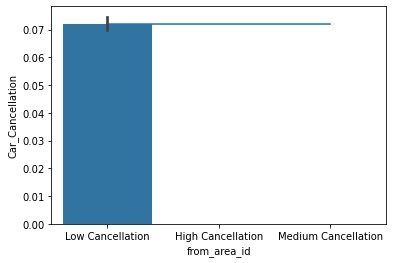

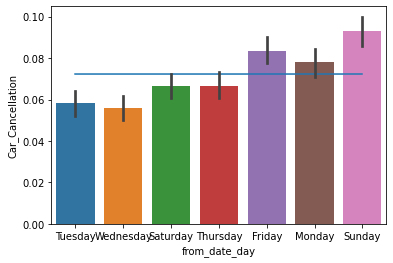

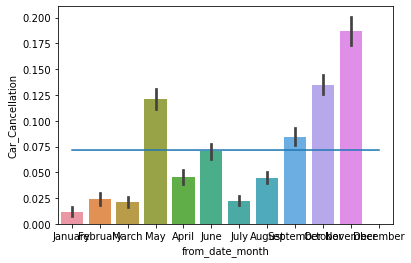

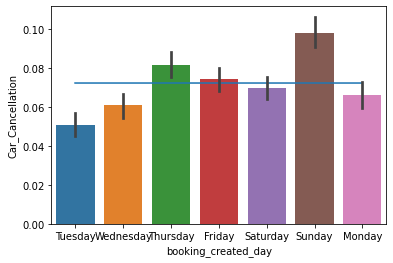

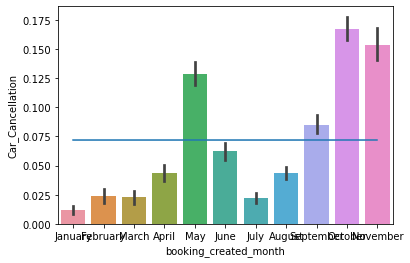

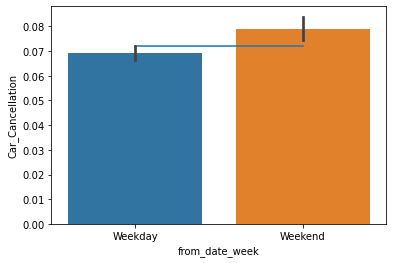

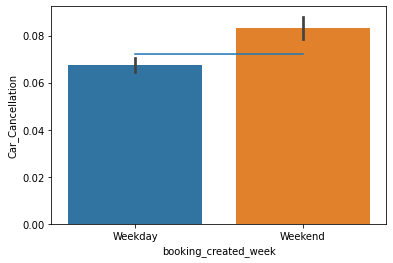

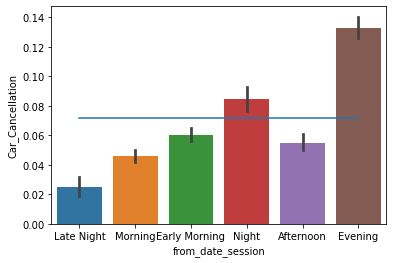

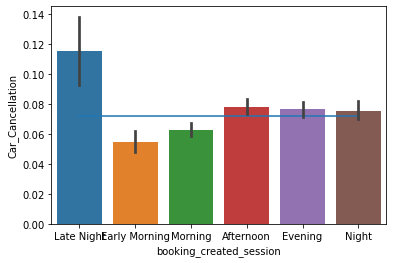

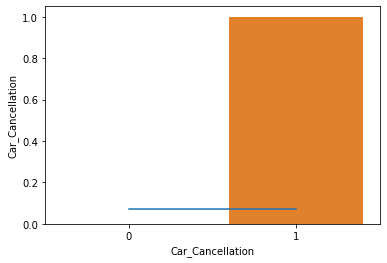

In [143]:
for col in X_char_merge:
    plt.figure()
    sns.lineplot(x=col,y=X_char_merge['Car_Cancellation'].mean(), data=X_char_merge)
    sns.barplot(x=col, y='Car_Cancellation', data=X_char_merge)
plt.show()

In [168]:
#1 Hot encoding
#Create dummy features with n-1 features from n features
#Why n-1, because last feature we can create by using other features
X_char_dum = pd.get_dummies(X_char, drop_first=True)

In [169]:
X_char_dum.shape

(43431, 47)

In [170]:
X_char_dum.head()

,from_area_id_Low Cancellation,from_area_id_Medium Cancellation,from_date_day_Monday,from_date_day_Saturday,from_date_day_Sunday,from_date_day_Thursday,from_date_day_Tuesday,from_date_day_Wednesday,from_date_month_August,from_date_month_December,from_date_month_February,from_date_month_January,from_date_month_July,from_date_month_June,from_date_month_March,from_date_month_May,from_date_month_November,from_date_month_October,from_date_month_September,booking_created_day_Monday,booking_created_day_Saturday,booking_created_day_Sunday,booking_created_day_Thursday,booking_created_day_Tuesday,booking_created_day_Wednesday,booking_created_month_August,booking_created_month_February,booking_created_month_January,booking_created_month_July,booking_created_month_June,booking_created_month_March,booking_created_month_May,booking_created_month_November,booking_created_month_October,booking_created_month_September,from_date_week_Weekend,booking_created_week_Weekend,from_date_session_Early Morning,from_date_session_Evening,from_date_session_Late Night,from_date_session_Morning,from_date_session_Night,booking_created_session_Early Morning,booking_created_session_Evening,booking_created_session_Late Night,booking_created_session_Morning,booking_created_session_Night
0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [171]:
#Concate X_num and X_char Data frame
X_all = pd.concat([X_char_dum, X_num], axis=1, join = 'inner')

In [172]:
X_all

,from_area_id_Low Cancellation,from_area_id_Medium Cancellation,from_date_day_Monday,from_date_day_Saturday,from_date_day_Sunday,from_date_day_Thursday,from_date_day_Tuesday,from_date_day_Wednesday,from_date_month_August,from_date_month_December,from_date_month_February,from_date_month_January,from_date_month_July,from_date_month_June,from_date_month_March,from_date_month_May,from_date_month_November,from_date_month_October,from_date_month_September,booking_created_day_Monday,booking_created_day_Saturday,booking_created_day_Sunday,booking_created_day_Thursday,booking_created_day_Tuesday,booking_created_day_Wednesday,booking_created_month_August,booking_created_month_February,booking_created_month_January,booking_created_month_July,booking_created_month_June,booking_created_month_March,booking_created_month_May,booking_created_month_November,booking_created_month_October,booking_created_month_September,from_date_week_Weekend,booking_created_week_Weekend,from_date_session_Early Morning,from_date_session_Evening,from_date_session_Late Night,from_date_session_Morning,from_date_session_Night,booking_created_session_Early Morning,booking_created_session_Evening,booking_created_session_Late Night,booking_created_session_Morning,booking_created_session_Night,point_to_point,hourly_rental,online_booking,mobile_site_booking,Distance_in_KM
0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,3.975770
1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,13.995053
2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,12.708431
3,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,9.525167
4,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,14.699802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43426,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,10.711983
43427,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,21.345632
43428,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,7.470924
43429,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.594399


### Train Test Split

In [224]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, Y, test_size=0.3, random_state=42)
#Selected random state 6, my sample should 
#be the good representation of population
#Randome state, its a seed number
#Selected random state = 6 as Car Cancellation rate in training and testing data are statistically equal
#Car Cancellation rate in training:Car_Cancellation    0.072
#Car Cancellation rate in testing:Car_Cancellation    0.071

In [225]:
print(f'Shape of training data:{X_train.shape}')
print(f'Shape of testing data:{X_test.shape}')
print(f'Car Cancellation rate in training:{y_train.mean()}')
print(f'Car Cancellation rate in testing:{y_test.mean()}')

Shape of training data:(30401, 52)
Shape of testing data:(13030, 52)
Car Cancellation rate in training:0.07243182790039801
Car Cancellation rate in testing:0.0713737528779739


## Building Model

### Decision Tree Model

In [226]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='gini', random_state=42)

In [227]:
#Select the best parameter using GridSearchCV
from sklearn.model_selection import GridSearchCV
param = {'max_depth':[3, 4, 5, 6, 7], 'min_samples_split':[50,120,180,200,250]}
dtree_grid = GridSearchCV(dtree, param_grid= param, n_jobs = 2, cv=10)
dtree_grid.fit(X_train, y_train)
print('Best Parameters using GridSearchCV:',dtree_grid.best_params_)

Best Parameters using GridSearchCV: {'max_depth': 3, 'min_samples_split': 50}


In [228]:
##Set the best parameter given by GridSearchCV to dtree
dtree = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=5, min_samples_split=50)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=50, random_state=42)

### Random Forest Model


In [270]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

In [255]:
#Select the best parameter using GridSearchCV
param = {'max_depth':[4, 5 ,6 ,7], 'min_samples_split':[50,120,180,200,250]}
rfc_grid = GridSearchCV(rfc, param_grid=param, cv=10, n_jobs = 2)
rfc_grid.fit(X_train, y_train)
print('Best Parameters using GridSearchCV:',rfc_grid.best_params_)

Best Parameters using GridSearchCV: {'max_depth': 3, 'min_samples_split': 50}


In [295]:
##Set the best parameter given by GridSearchCV to dtree
rfc = RandomForestClassifier(criterion='gini', random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Logistic Regression

In [247]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

## Model Evaluation

In [296]:
#Predict method will give 50% probability, 
#its probability is >0.5 then it will be class 1
y_pred_dtree = dtree.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
y_pred_logreg = logreg.predict(X_test)

In [235]:
from sklearn import metrics

### Decision Tree

In [236]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_dtree))
print("Precision",metrics.precision_score(y_test, y_pred_dtree))
print("Recall",metrics.recall_score(y_test, y_pred_dtree))
print("f1_score",metrics.f1_score(y_test, y_pred_dtree))

Accuracy: 0.9293169608595548
Precision 0.5391304347826087
Recall 0.06666666666666667
f1_score 0.11866028708133972


Text(0.5, 1.0, 'Confusion Metrics for Decision Tree')

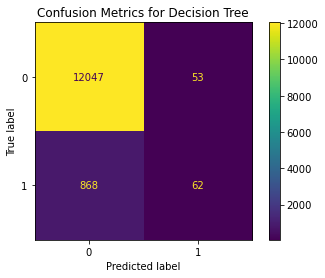

In [299]:
metrics.plot_confusion_matrix(dtree, X_test, y_test)
plt.title('Confusion Metrics for Decision Tree')

### Random Forest

In [297]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rfc))
print("Precision",metrics.precision_score(y_test, y_pred_rfc))
print("Recall",metrics.recall_score(y_test, y_pred_rfc))
print("f1_score",metrics.f1_score(y_test, y_pred_rfc))

Accuracy: 0.9236377590176515
Precision 0.4405850091407678
Recall 0.2591397849462366
f1_score 0.3263371699390657


Text(0.5, 1.0, 'Confusion Metrics for Random Forest')

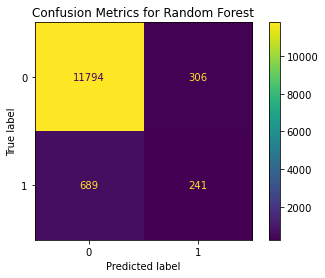

In [300]:
metrics.plot_confusion_matrix(rfc, X_test, y_test)
plt.title('Confusion Metrics for Random Forest')

### Logistic Regression

In [248]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_logreg))
print("Precision",metrics.precision_score(y_test, y_pred_logreg))
print("Recall",metrics.recall_score(y_test, y_pred_logreg))
print("f1_score",metrics.f1_score(y_test, y_pred_logreg))

Accuracy: 0.9280122793553338
Precision 0.475
Recall 0.08172043010752689
f1_score 0.1394495412844037


Text(0.5, 1.0, 'Confusion Metrics for Logistic Regression')

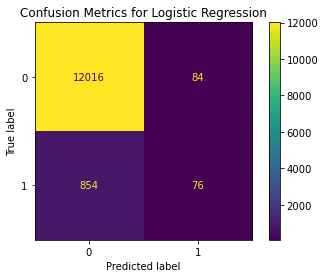

In [301]:
metrics.plot_confusion_matrix(logreg, X_test, y_test)
plt.title('Confusion Metrics for Logistic Regression')